In [5]:
from IPython.display import Markdown, display
display(Markdown("README.md"))

## Simple FCS plotter
This is a Jupyter notebook intended to take one or more .FCS flow cytometry files, and produce a 2D histogram from them.

It is largely just a wrapper around fcsparser https://github.com/eyurtsev/fcsparser

### Author(s): 
Timothy R. Fallon
https://orcid.org/0000-0002-3048-7679

### Version:
2021-07-07, Draft 1

### Confirmed instruments it works with:
- Luminex Muse - https://www.luminexcorp.com/muse-cell-analyzer/ 

### Dependencies
They (and more) are all within the Vagrantfile, but if you'd like to run standalone:
- fcsparser (https://github.com/eyurtsev/fcsparser)
- numpy
- matplotlib
- seaborn

### How to use:
1. Put your .FCS files and the Jupyter notebook in a subordinate directory, e.g. 20210707_Genome_sizing_QC
2. Produce the `Vagrantfile` and spin up the VM with all the dependencies to run the Notebook (See code blocks below, in short: `vagrant up`). 
    - Note: This expects the Vagrantfile to be in the parent directory of the subordinate directory made in step (1)
3. Enter the VM (via `vagrant ssh`), 
4. Startup the Jupyter notebook via Jupyter lab using the `run_jupyter.sh` script. (See 2 code blocks below)
5. Use the Jupyter produced link at 127.0.0.1 (localhost) and port 13337. Should be something like ' http://127.0.0.1:13337/lab?token=400cd49f901b668534443b7bf2a453c36754ee677ebf7c02 '

In short, once you have Vagrant installed, execute:
```
vagrant up ##This will take awhile, as all the dependencies have to get installed
vagrant ssh
cd /vagrant
run_jupyter.sh
```



In [9]:
%pycat ../Vagrantfile

##
## This is the content of a Vagrantfile for Vagrant (https://www.vagrantup.com),
## which allows for running of these Jupyter notebooks via a Vagrant VM
## You need VirtualBox (https://www.virtualbox.org) or another VM application to use Vagrant
## Why use a VM? I found installing dependencies on my base environment to be a headache.
## This Linux VM seems more reliable.
##
## In short, once you have Vagrant installed, execute:
## vagrant up ##This will take awhile, as all the dependencies have to get installed
## vagrant ssh
## cd /vagrant
## run_jupyter.sh
##

Vagrant.configure("2") do |config|
  config.vm.box = "sylabs/singularity-3.7-ubuntu-bionic64"
  config.vm.provider "virtualbox" do |v|
    v.cpus = 4
    v.memory = 2048
  end
  config.vm.network "forwarded_port", guest: 13337, host: 13337, protocol: "tcp",
    auto_correct: true
  config.vm.network "forwarded_port", guest: 5900, host: 59007, protocol: "tcp",
    auto_correct: true
  config.ssh.forward_x11 = true
  config.vm

In [10]:
%pycat run_jupyter.sh

#! /bin/bash
## See: https://ipython.readthedocs.io/en/stable/interactive/magics.html#cellmagic-writefile
echo "****"
echo "In order to use this Jupyter notebook, use the 127.0.0.1 (localhost)"
echo "http link produced by Jupyter below."
echo "and navigate using the browser on the VM host (e.g., your laptop)"
echo "Vagrant is already set up to forward this port properly."
echo "****"
echo "Sleeping for 5 seconds..."
sleep 5
echo "Running jupyter notebook with cmd: jupyter lab --ip=0.0.0.0 --port 13337 --no-browser"
jupyter lab --ip=0.0.0.0 --port 13337 --no-browser
##


In [11]:
##Have to make run_jupyter executable.
!chmod +x run_jupyter.sh

In [12]:
import getpass
user = getpass.getuser()
if user != 'vagrant':
    print("user is:",user,"not 'vagrant'")
    print("probably not running in a VM")

user was: tim not 'vagrant'
probably not running in a VM


In [13]:
import fcsparser ##Parses the FCS files https://github.com/eyurtsev/fcsparser
##See also: https://github.com/eyurtsev/FlowCytometryTools

import seaborn ##Graphical plotting library
import matplotlib ##Graphical plotting library

import numpy ##Numerical manipulation library
from collections import OrderedDict
cmap = matplotlib.cm.get_cmap('Spectral')

In [14]:
%pylab inline
histo = False

Populating the interactive namespace from numpy and matplotlib


In [15]:
##This is a special modification to properly parse the Luminex Muse .FCS files.
## See https://github.com/eyurtsev/fcsparser/issues/24
import glob
import os.path
files = glob.glob("ADM_*.VIA.FCS")
for f in files:
    handle = open(f,"rb")
    data = handle.read()
    split_data = data.split(b"FCS3.0")
    for s in range(1,len(split_data)):
        filename = f+"_"+str(s)+".FCS"
        if os.path.isfile(filename):
            ##Don't rewrite the file if it is already there
            continue
        handle = open(filename,"wb")
        handle.write(b"FCS3.0"+split_data[s])
        handle.close()

In [16]:
from natsort import natsorted
files = glob.glob("*.FCS_*.FCS")
files = natsorted(files)
print(files)

['example_24JUN2021_090627.VIA.FCS_4.FCS']


In [17]:
keep_string = ""

CCMP2941 24-JUN-2021 09:26:20 Yellow Fluorescence (YEL-HLin) median: 5.0276504
CCMP2941 24-JUN-2021 09:26:20 Cell Size (FSC-HLog) median: 0.2301087
determining limits...
plotting hist2d...
Plotting 1D histograms on X and Y axes
saving plot to plots/CCMP2941 24-JUN-2021 09:26:20.png...
showing plot...


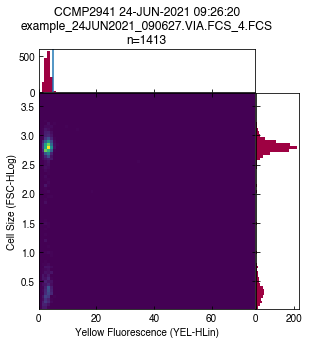

In [18]:
## Make plots with fcsparser + pandas + matplotlib alone

## This plotting is a little finicky, but works OK.

## Based off this example: https://matplotlib.org/2.0.2/examples/pylab_examples/scatter_hist.html

from pathlib import Path

i=0
for f in files:
    meta , data = fcsparser.parse(f,data_set=0)
    sample_name = meta['GTI$SAMPLEID']+" "+meta['GTI$ANALYSISDATE']+" "+meta['GTI$ANALYSISTIME']
    if keep_string not in sample_name.lower():
        continue
    
    ## Available variables, at least for the Muse.
    #['Forward Scatter (FSC-HLin)', 'Forward Scatter Width (FSC-W)',
    #   'Yellow Fluorescence (YEL-HLin)', 'Yellow Fluorescence Width (YEL-W)',
    #   'Red Fluorescence (RED-HLin)', 'Red Fluorescence Width (RED-W)', 'Time',
    #   'Cell Size (FSC-HLog)', 'Viability (YEL-HLog)',
    #   'Nucleation (RED-HLog)']
    #col1='Yellow Fluorescence (YEL-HLin)'
    #col2='Forward Scatter (FSC-HLin)'
    
    col1='Yellow Fluorescence (YEL-HLin)' ##Viability (YEL-HLog)
    col2='Cell Size (FSC-HLog)'
    col3='Forward Scatter (FSC-HLin)'
    
    ### Calculate median
    subdata=data[data[col1] > 5] ##Filter based on col1 threshold, just used for Median calculation
    subdata=subdata[subdata[col2] < 2.0]
    col1_median = numpy.median(subdata[col1].values)
    col2_median = numpy.median(subdata[col2].values)
    ## Converting from log to linear
    #print(sample_name,col1+" median:",col1_median,"({lin})".format(lin=10**col1_median))
    #print(sample_name,col2+" median:",col2_median,"({lin})".format(lin=10**col2_median))
    ## If already linear, don't need to convert
    print(sample_name,col1+" median:",col1_median)
    print(sample_name,col2+" median:",col2_median)
    
    
    ### Warning: If the Flow cytometry events are outside these limits, they aren't shown on the plots/histograms.
    ### For minimum interpretation bias, set the min to 0, and the maxes to something fairly large.
    x_min = 0
    x_max = 75
    y_min = 0.02
    y_max = 3.7
    
    print("determining limits...")
    # now determine nice limits by hand:
    binwidth_x = 1 ##Originally 0.01
    binwidth_y = 0.05
    lim_x = np.ceil(np.abs([x_min , x_max]).max() / binwidth_x) * binwidth_x
    lim_y = np.ceil(np.abs([y_min, y_max]).max() / binwidth_y) * binwidth_y
        
    bins_x = np.arange(x_min, x_max + binwidth_x, binwidth_x)
    bins_y = np.arange(y_min, y_max + binwidth_y, binwidth_y)
    
    x=data[col1]
    y=data[col2]
    
    # definitions for the axes
    left, width = 0, 1
    bottom, height = 0, 1
    spacing = 0.005


    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.2]
    rect_histy = [left + width + spacing, bottom, 0.2, height]
    
    ## BELOW scatter plot
    
    # start with a rectangular Figure
    pyplot.figure(figsize=(3, 3))

    ## Define the axes
    ax_scatter = pyplot.axes(rect_scatter)
    ax_scatter.tick_params(direction='in', top=True, right=True)
    
    ax_scatter.set_xlim(x_min,x_max) ## 0,3.7 for H-LOG
    ax_scatter.set_ylim(y_min,y_max) ## 0,3.7 for H-LOG
    
    ax_histx = pyplot.axes(rect_histx)
    ax_histx.tick_params(direction='in', labelbottom=False)
    ax_histy = pyplot.axes(rect_histy)
    ax_histy.tick_params(direction='in', labelleft=False)

    ## Draw vertical lines on histograms
    ax_histx.axvline(x=col1_median)
    
    rgba = cmap(i*0.1)
    
    print("plotting hist2d...")
    # the scatter plot:
    ax_scatter.hist2d(x, y,bins=[bins_x,bins_y]) ##Color=rgba
    ax_scatter.set_xlabel(col1)
    ax_scatter.set_ylabel(col2)
    
    print("Plotting 1D histograms on X and Y axes")
    ax_histx.hist(x, bins=bins_x,color=rgba)
    ax_histx.set_title(sample_name+"\n"+f+"\nn="+str(len(x)))
    ax_histy.hist(y, bins=bins_y, orientation='horizontal',color=rgba)

    ax_histx.set_xlim(ax_scatter.get_xlim())
    ax_histy.set_ylim(ax_scatter.get_ylim())
    
    fig = pyplot.gcf()
    plot_name = "plots/"+sample_name+".png"
    Path("plots").mkdir(parents=False, exist_ok=True)
    print("saving plot to {PLOT}...".format(PLOT=plot_name))
    fig.savefig(plot_name,bbox_inches='tight')
    
    print("showing plot...")
    pyplot.show()
    

    ## Below: HISTOGRAM
    #if histo == False:
    #    pyplot.xlabel(col1)
    #    pyplot.ylabel(col2)
    #    #pyplot.show(scatter(data[col1], data[col2], alpha=0.005, color='gray'))
    #    pyplot.xlim(0,2000)
    #    rgba = cmap(i*0.05)
    #    hist(data[col2], color=rgba,bins=100,alpha=0.3)
    #    #pyplot.show(hist(data[col2], color='gray',bins=500))
    
    i+=1


In [19]:
##Using FlowCytometryTools instead:
# import FlowCytometryTools

# for f in files:
#     sample = FlowCytometryTools.FCMeasurement(ID=f, datafile=f)
#     sample_name = sample.meta['GTI$SAMPLEID']+" "+sample.meta['GTI$ANALYSISDATE']+" "+sample.meta['GTI$ANALYSISTIME']
#     if keep_string not in sample_name.lower():
#         continue
#     print(sample.channel_names)
#     fsc_gate_a = FlowCytometryTools.ThresholdGate(1.5, ['Cell Size (FSC-HLog)'], region='above')
#     yel_gate_a = FlowCytometryTools.ThresholdGate(3.2, ['Viability (YEL-HLog)'], region='above')
#     width_gate_b = FlowCytometryTools.ThresholdGate(8.5, ['Yellow Fluorescence Width (YEL-W)'], region='below')
#     width_gate_a = FlowCytometryTools.ThresholdGate(2.5, ['Yellow Fluorescence Width (YEL-W)'], region='above')
#     red_gate_b = FlowCytometryTools.ThresholdGate(5.0, ['Nucleation (RED-HLog)'], region='below')
#     yel_gate_b = FlowCytometryTools.ThresholdGate(5.0, ['Viability (YEL-HLog)'], region='below')

#     print(f,sample.meta['GTI$SAMPLEID'])
#     pyplot.show(sample.plot(['Viability (YEL-HLog)','Cell Size (FSC-HLog)'], gates=[fsc_gate_a,yel_gate_a], bins=100))
#     print(f,sample.meta['GTI$SAMPLEID'])
#     pyplot.show(sample.plot(['Yellow Fluorescence Width (YEL-W)','Nucleation (RED-HLog)'],gates=[width_gate_a,width_gate_b],bins=100))
#     #print(f,sample.meta['GTI$SAMPLEID'])
#     #pyplot.show(sample.plot(['Yellow Fluorescence Width (YEL-W)','Red Fluorescence Width (RED-W)'],gates=[width_gate_a,width_gate_b],bins=100))
#     print(f,sample.meta['GTI$SAMPLEID'])
#     pyplot.show(sample.plot(['Viability (YEL-HLog)','Nucleation (RED-HLog)'],gates=[red_gate_b,yel_gate_b],bins=100))
#     gated_sample = sample.gate(fsc_gate_a)
#     gated_sample = gated_sample.gate(yel_gate_a)
#     gated_sample = gated_sample.gate(width_gate_b)
#     gated_sample = gated_sample.gate(width_gate_a)
#     gated_sample = gated_sample.gate(red_gate_b)
#     gated_sample = gated_sample.gate(yel_gate_b)
#     print(f,sample.meta['GTI$SAMPLEID'])
#     pyplot.show(gated_sample.plot(['Viability (YEL-HLog)','Cell Size (FSC-HLog)'], bins=100))
#     print(f,sample.meta['GTI$SAMPLEID'])
#     pyplot.show(gated_sample.plot(['Yellow Fluorescence Width (YEL-W)','Nucleation (RED-HLog)'], bins=100))
#     print(f,sample.meta['GTI$SAMPLEID'])
#     pyplot.show(gated_sample.plot(['Viability (YEL-HLog)','Nucleation (RED-HLog)'], bins=100))
    
#     ##Start plotting of 2D histogram w/ histogram edges
#     #col1='Viability (YEL-HLog)'
#     col1='Yellow Fluorescence (YEL-HLin)'
#     #col2='Cell Size (FSC-HLog)'
#     col2='Forward Scatter (FSC-HLin)'
#     col3='Red Fluorescence (RED-HLin)'
    
#     data = gated_sample.data
    
#     #subdata=data[data[col1]] ##In case I wanted to do a dataframe selection
#     subdata=data
#     print(sample_name,col1+" median:",numpy.median(subdata[col1].values))
#     print(sample_name,col2+" median:",numpy.median(subdata[col2].values))
#     print(sample_name,col3+" median:",numpy.median(subdata[col3].values))
    
    
#     xy=data[[col1,col2]]
#     #xy=xy[xy[col1] < 257]
#     #xy=xy[xy[col2] < 257]
#     x=xy[col1]
#     y=xy[col2]
#     # definitions for the axes
#     left, width = 0, 1
#     bottom, height = 0, 1
#     spacing = 0.005


#     rect_scatter = [left, bottom, width, height]
#     rect_histx = [left, bottom + height + spacing, width, 0.2]
#     rect_histy = [left + width + spacing, bottom, 0.2, height]
    
#     ##BELOW scatter plot / 2D hist plot
    
#     # start with a rectangular Figure
#     pyplot.figure(figsize=(3, 3))

#     ax_scatter = pyplot.axes(rect_scatter)
#     ax_scatter.tick_params(direction='in', top=True, right=True)
#     ax_histx = pyplot.axes(rect_histx)
#     ax_histx.tick_params(direction='in', labelbottom=False)
#     ax_histy = pyplot.axes(rect_histy)
#     ax_histy.tick_params(direction='in', labelleft=False)
    
#     # the scatter plot:
#     ax_scatter.hist2d(x, y,bins=100) ##Color=rgba
#     ax_scatter.set_xlim(0,x.max())
#     ax_scatter.set_ylim(0,y.max())
#     ax_scatter.set_xlabel(col1)
#     ax_scatter.set_ylabel(col2)

#     # now determine nice limits by hand:
#     binwidth = 4
#     lim = np.ceil(np.abs([x, y]).max() / binwidth) * binwidth

#     bins = np.arange(-lim, lim + binwidth, binwidth)
#     ax_histx.hist(x, bins=100)
#     ax_histx.set_title(sample_name+"\n"+f+"\nn="+str(len(x))+" x_med:"+str(round(numpy.median(x),1))+" sd%:"+str(round(numpy.std(x)/numpy.median(x)*100,1)))
#     ax_histy.hist(y, bins=100, orientation='horizontal')

#     ax_histx.set_xlim(ax_scatter.get_xlim())
#     ax_histy.set_ylim(ax_scatter.get_ylim())

#     pyplot.show()